In [1]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [2]:
path = "/eos/experiment/fcc/ee/tmp/testmatching/"
mode = "Bd2DstTauNuTAUHADNU"

file = uproot.open(path+f"events_{mode}.root")
tree = file['events']
events = tree.arrays(library="ak", how="zip")

n_keep = 100000
events = events[:n_keep] 

Get the parent info for the particles, using `RPMC_parentindex` to find the info in the MC particle container

In [3]:
events["RP","pdg"] = events["MC","pdg"][events["RP","MC_parentindex"]]

Keep the reco particle info

In [4]:
rp = events["RP"]
p_cut = rp["p"] > 1.
rp = rp[p_cut]

Keep the pions

In [5]:
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]

Make $3\pi$ combinations

In [6]:
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

Keep only the pions which come from a $\tau$

In [7]:
tau_parent_cut_pi1 = abs(tau["pi_1"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]

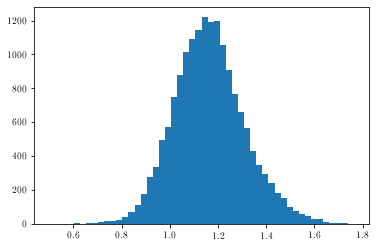

In [8]:
plt.hist(ak.flatten(tau["mass"]),bins=50)
plt.show()